In [1]:
!python -m pip install "../."

Processing c:\users\danii\program\python\project\imgdoc
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imgdoc: filename=imgdoc-0.0.3-py3-none-any.whl size=11826 sha256=5b6262f88f29ab9dbf3b9f17941ca894aee677bbf674a1ed874ef6012c7852b3
  Stored in directory: C:\Users\danii\AppData\Local\Temp\pip-ephem-wheel-cache-ktm5p_m6\wheels\b8\e3\4a\f1f494124c2259921bd58533df69bb605814dcc87a7223eb4d
Successfully built imgdoc
  Attempting uninstall: imgdoc
    Found existing installation: imgdoc 0.0.3
    Uninstalling imgdoc-0.0.3:
      Successfully uninstalled imgdoc-0.0.3


In [2]:
import pytesseract
from img_doc.extractors.word_extractors import BaseWordExtractor
from img_doc.data_structures import Word
import numpy as np
from typing import List

class TesseractWordExtractor(BaseWordExtractor):
    def extract_from_img(self, img: np) -> List[Word]:
        tesseract_bboxes = pytesseract.image_to_data(
            config="-l rus",
            image=img,
            output_type=pytesseract.Output.DICT)
        word_list = []
        for index_bbox, level in enumerate(tesseract_bboxes["level"]):
            if level == 5:
                word = Word(text = tesseract_bboxes["text"][index_bbox])
                word.set_point_and_size({
                    "x_top_left":tesseract_bboxes["left"][index_bbox],
                    "y_top_left":tesseract_bboxes["top"][index_bbox],
                    "width":tesseract_bboxes["width"][index_bbox],
                    "height": tesseract_bboxes["height"][index_bbox],
                })
                word_list.append(word)
        return word_list

In [3]:
from img_doc.data_structures import Image
import os

image = Image()
image.set_img_from_path(os.path.join("img", "4.jpg"))

word_ext = TesseractWordExtractor()
words = word_ext.extract_from_img(image.img)

In [4]:
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
kmeanext = KMeanBlockExtractor()


In [109]:
import numpy as np
distans = []

for i, ed_k in enumerate(edges_kmean):
    top_dist =  words[i].segment.y_top_left - words[ed_k[0]].segment.y_bottom_right 
    right_dist = words[ed_k[1]].segment.x_top_left  -words[i].segment.x_bottom_right
    bottom_dist = words[ed_k[2]].segment.y_top_left - words[i].segment.y_bottom_right
    left_dist  = words[i].segment.x_top_left - words[ed_k[3]].segment.x_bottom_right
    distans.append([top_dist, right_dist, bottom_dist, left_dist])
#     dist = [0, 0, 0, 0]
#     for j, k in enumerate(ed_k):
#         x1, y1 =  words[i].segment.get_center()
#         x2, y2 =  words[k].segment.get_center() 
#         dist[j] = ((x1-x2)**2+(y1-y2)**2)**0.5
#     distans.append(dist)
    
    
    

In [110]:
distribution_h = []
distribution_w = []

for dist in distans:
    if dist[0] > 0:
        distribution_h.append(dist[0])
    if dist[1] > 0:
        distribution_w.append(dist[1])   
    if dist[2] > 0:
        distribution_h.append(dist[2])
    if dist[3] > 0:
        distribution_w.append(dist[3]) 
        
def get_row_dist(distribution_h):
    y, x = np.histogram(distribution_h)
    for i in range(len(y)-1):
        if y[i] >= 0 and y[i+1] <= 0:
            return x[i+1]
    return x[-1]
        
def get_word_dist(distribution_w):
    y, x = np.histogram(distribution_w)
    for i in range(len(y)-1):
        if y[i] >= 0 and y[i+1] <= 0:
            return x[i+1]
    return x[-1]

In [111]:
dist_row = get_row_dist(distribution_h)
dist_word = get_word_dist(distribution_w)
print(dist_word, dist_row)

64.2 177.4


In [112]:
dist_row = np.mean(distribution_h)
dist_word = np.mean(distribution_w)
print(dist_word, dist_row)

6.986193293885601 38.981549815498155


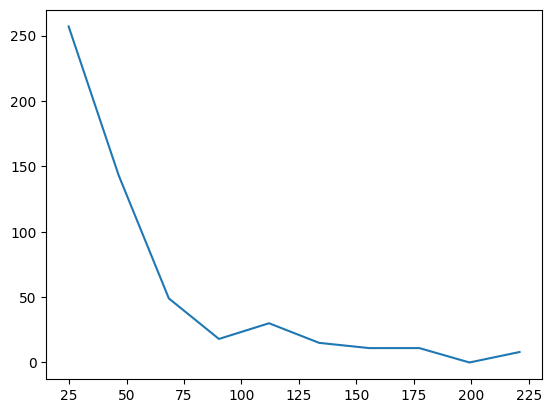

In [113]:
y, x = np.histogram(distribution_h)
plt.plot(x[1:], y)

In [114]:
from img_doc.data_structures import Graph, Node, Edge

In [115]:
graph = Graph()
edges = []
index_word_from_node = dict()
node_from_index_word = dict()

for n1, ed_k in enumerate(edges_kmean):
    for vec, n2 in enumerate(ed_k):
        set_n = {n1, n2}
        if n1 != n2 and not (set_n in edges):
            if (vec in (0, 2)) and (distans[n1][vec] < dist_row) and (distans[n1][vec] > 0):
                edges.append(set_n)
            elif (vec in (1, 3)) and (distans[n1][vec] < dist_word) and (distans[n1][vec] > 0):
                edges.append(set_n)
for i, word in enumerate(words):
    c1x, c1y = word.segment.get_center()
    index = graph.add_node(c1x, c1y) # index_word+1

for edge in edges:
    n_list = list(edge)
    n1, n2 = n_list[0]+1, n_list[1]+1
    graph.add_edge(n1, n2)

In [116]:
distans

[[-15, 3, 202, -51],
 [-29, 13, 153, 3],
 [-15, -124, 52, 13],
 [-18, 23, 96, -232],
 [-15, 24, 55, 23],
 [-16, 24, 60, 24],
 [52, -167, 134, 24],
 [-7, -804, 29, -804],
 [-13, 5, 67, -70],
 [55, 4, 25, 5],
 [29, 5, 64, 4],
 [-13, 5, 25, 5],
 [60, -123, 22, 5],
 [96, 6, 25, 4],
 [-13, 7, 26, 6],
 [25, 6, 27, 7],
 [-16, 7, 25, 6],
 [25, 7, 202, 7],
 [22, 20, 26, 7],
 [153, -147, 24, 5],
 [-14, 5, 121, -50],
 [-11, 4, 124, 5],
 [25, 5, 161, 4],
 [67, 5, 128, 5],
 [26, 5, 164, 5],
 [27, 5, 212, 5],
 [25, 5, 164, 5],
 [64, 5, 24, 5],
 [26, 4, 161, 38],
 [26, 5, 158, 4],
 [202, 5, 43, 5],
 [24, 5, 42, 5],
 [134, -100, 48, 5],
 [24, -804, 125, -804],
 [43, 5, 108, -35],
 [42, 4, 105, 5],
 [48, 3, 161, 4],
 [-12, -95, 110, 3],
 [-15, 9, 45, -7],
 [124, 7, 21, 9],
 [128, 61, 38, 7],
 [21, 6, 7, -87],
 [161, 6, 50, 6],
 [164, 5, 7, 6],
 [164, 6, 10, 5],
 [125, 7, 53, 6],
 [202, 7, 38, 7],
 [158, 8, 101, 7],
 [108, 7, 38, 8],
 [105, 6, 32, 7],
 [110, -109, 35, 6],
 [45, 6, 34, -28],
 [7, 5, 13, 

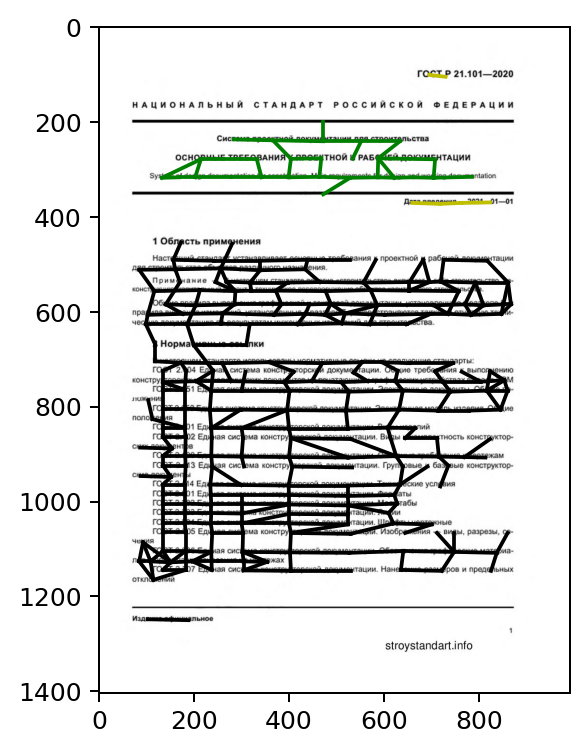

In [117]:
import matplotlib.pyplot as plt

color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
plt.imshow(image.img)
for i, r in enumerate(graph.get_related_graphs()):
    for edge in r.get_edges():
        x, y = edge.get_line()
        plt.plot(x, y, color[i%3])

In [42]:
words[1].segment.y_bottom_right, words[1].segment.y_top_left

(118, 89)

In [91]:
edges_kmean

[[0, 1, 4, 1],
 [1, 0, 4, 0],
 [2, 17, 5, 1],
 [3, 9, 8, 7],
 [15, 15, 15, 15],
 [16, 16, 16, 16],
 [6, 7, 20, 20],
 [3, 8, 22, 21],
 [3, 9, 23, 7],
 [3, 10, 24, 8],
 [10, 11, 25, 9],
 [11, 12, 26, 10],
 [12, 13, 36, 11],
 [14, 14, 14, 14],
 [13, 13, 13, 13],
 [4, 4, 4, 4],
 [5, 5, 5, 5],
 [2, 6, 20, 5],
 [27, 38, 27, 38],
 [28, 28, 28, 28],
 [29, 29, 29, 29],
 [31, 31, 31, 31],
 [32, 32, 32, 32],
 [33, 33, 33, 33],
 [9, 25, 59, 33],
 [34, 34, 34, 34],
 [35, 35, 35, 35],
 [38, 38, 38, 38],
 [39, 39, 39, 39],
 [40, 40, 40, 40],
 [41, 41, 41, 41],
 [42, 42, 42, 42],
 [44, 44, 44, 44],
 [47, 47, 47, 47],
 [25, 25, 25, 25],
 [26, 26, 26, 26],
 [12, 37, 64, 35],
 [13, 37, 66, 36],
 [27, 27, 27, 27],
 [28, 28, 28, 28],
 [29, 29, 29, 29],
 [42, 42, 42, 42],
 [41, 41, 41, 41],
 [32, 32, 32, 32],
 [32, 32, 32, 32],
 [46, 46, 46, 46],
 [45, 45, 45, 45],
 [33, 33, 33, 33],
 [38, 49, 53, 48],
 [38, 50, 55, 48],
 [39, 51, 55, 51],
 [40, 50, 56, 50],
 [41, 43, 56, 56],
 [48, 54, 72, 54],
 [48, 53, 7

In [23]:
words[3].segment.y_bottom_right, words[28].segment.y_top_left

(189, 229)

In [124]:
graph.get_related_graphs()[0].get_nodes()[0].index

6

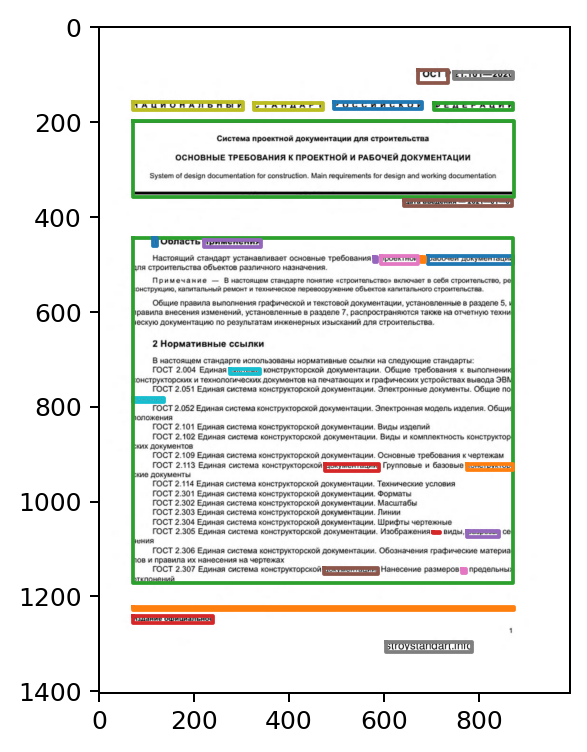

In [7]:
import matplotlib.pyplot as plt

color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
plt.imshow(image.img)

blocks = kmeanext.extract_from_word(words)
for block in blocks:
    x0 = block.segment.x_top_left
    y0 = block.segment.y_top_left
    x1 = block.segment.x_bottom_right
    y1 = block.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])